In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
except Exception:
    pass

In [2]:
# You will need numpy to be able to handle the data.
import numpy as np

# You will only use torchvision to load in the dataset.
# If you already have the data stored on your computer in a numpy friendly manner,
# then feel free to load it directly into numpy arrays.
import torchvision.transforms.v2 as v2
from torchvision import datasets

# Load the classes from DataEval that are helpful for bias
from dataeval.metrics.bias import balance, diversity, parity
from dataeval.utils import merge_metadata

In [3]:
# Download the data and then load it as a torch Tensor.
to_tensor = v2.ToImage()
ds = datasets.VOCDetection(root="./data", year="2011", image_set="train", download=True, transform=to_tensor)

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [4]:
# Verify the size of the loaded dataset
len(ds)

5717

In [5]:
# Check the label structure
ds[0][1]

{'annotation': {'folder': 'VOC2011',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [6]:
# Merge the dataset metadata into a single dictionary
metadata = merge_metadata((d[1] for d in ds), as_numpy=True)

# Extract the class_labels
class_labels = metadata.pop("name")

# Remove unwanted metadata
for k in ("folder", "filename", "annotation"):
    _ = metadata.pop(k)

/builds/jatic/aria/dataeval/src/dataeval/utils/metadata.py:128: UserWarning: Dropping nested list found in '('annotation', 'object', 'part')'.
  warnings.warn(f"Dropping nested list found in '{parent_keys + (k, )}'.")


In [7]:
# Verify that the lengths match
print(len(class_labels), len(metadata["database"]))

15774 15774


In [8]:
min_count = 1500

for continuous_variable in ["width", "height", "depth", "xmin", "ymin", "xmax", "ymax"]:
    counts, bin_edges = np.histogram(metadata[continuous_variable], bins="auto")

    if counts.min() < min_count:
        new_counts = []
        new_bin_edges = [bin_edges[0]]

        current_count = 0
        for i in range(len(counts)):
            current_count += counts[i]

            if current_count >= min_count:
                new_counts.append(current_count)
                new_bin_edges.append(bin_edges[i + 1])
                current_count = 0

        if current_count > 0:
            new_counts[-1] += current_count

        if counts[-1] < min_count:
            new_bin_edges[-1] = bin_edges[-1] + 1

        # Output the adjusted histogram
        new_counts = np.array(new_counts)
        new_bin_edges = np.array(new_bin_edges)

        discretized_variable = np.digitize(metadata[continuous_variable], bins=new_bin_edges, right=False)

    else:
        discretized_variable = np.digitize(metadata[continuous_variable], bins=bin_edges, right=False)

    metadata[continuous_variable] = list(discretized_variable)

In [9]:
bal = balance(class_labels, metadata)

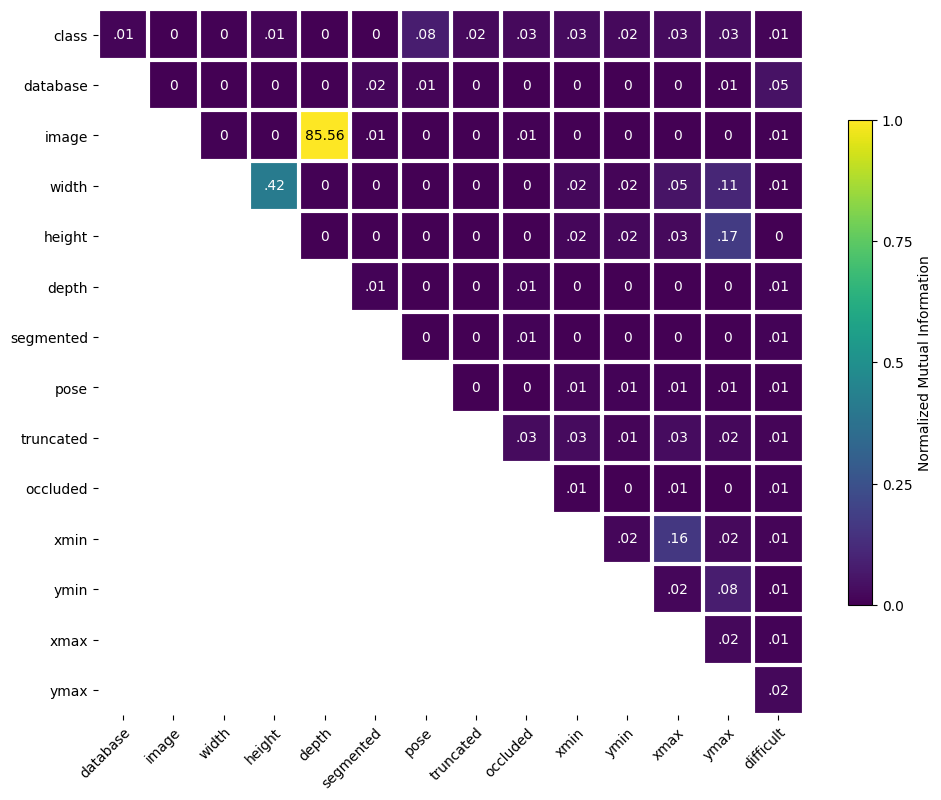

In [10]:
_ = bal.plot()

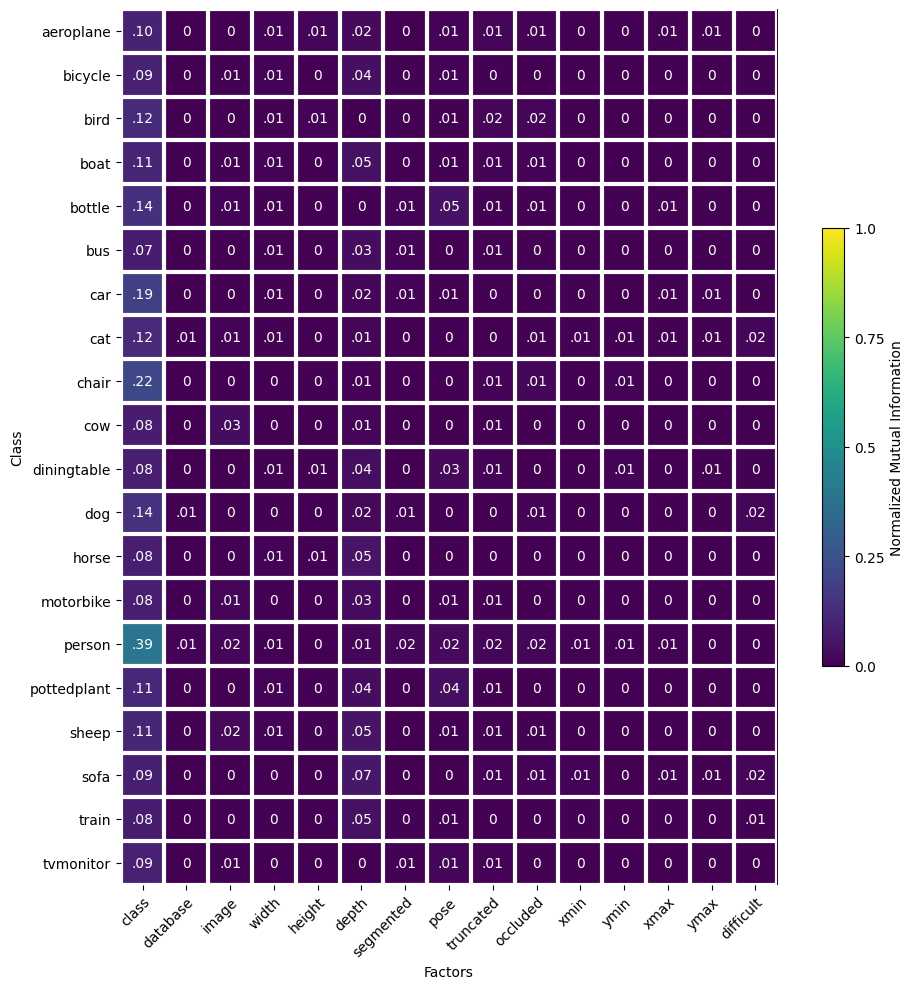

In [11]:
_ = bal.plot(plot_classwise=True)

In [12]:
div = diversity(class_labels, metadata)

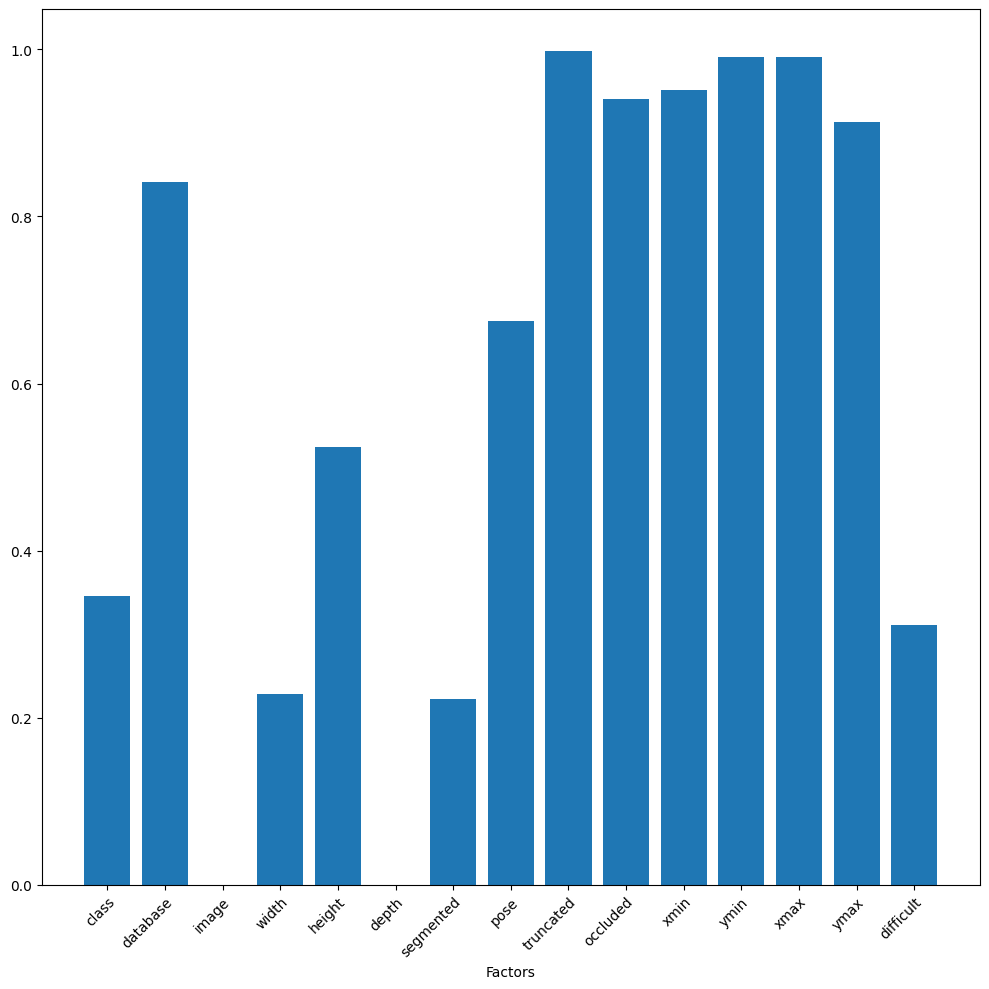

In [13]:
_ = div.plot()

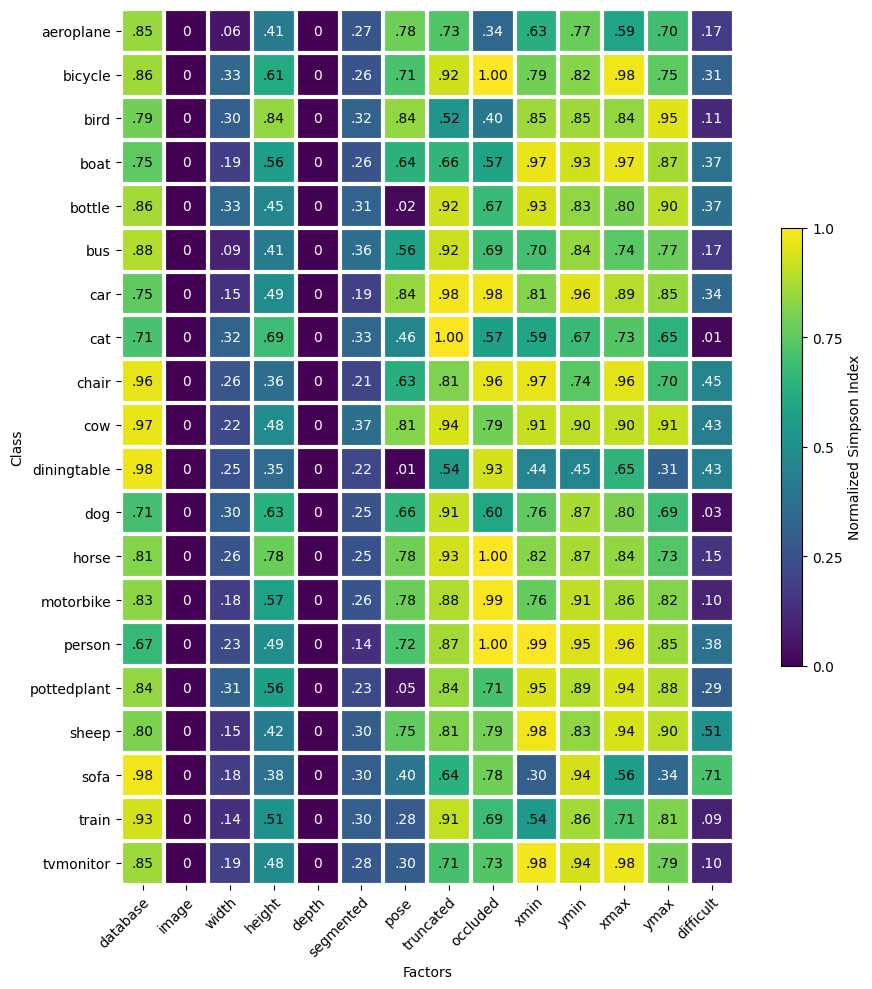

In [14]:
_ = div.plot(plot_classwise=True)

In [15]:
par = parity(class_labels, metadata)

/builds/jatic/aria/dataeval/src/dataeval/metrics/bias/parity.py:425: UserWarning: The following factors did not meet the recommended 5 occurrences for each value-label combination. 
            Recommend rerunning parity after adjusting the following factor-value-label combinations: 
width - value 2 - label 0: 4 occurrences
	
pose - value 0 - label 10: 3 occurrences
	value 1 - label 10: 2 occurrences
	value 3 - label 4: 1 occurrences
		label 10: 1 occurrences
	
xmin - value 8 - label 7: 4 occurrences
	
xmax - value 1 - label 7: 3 occurrences
	
ymax - value 1 - label 17: 4 occurrences
	
difficult - value 1 - label 7: 4 occurrences
	
  warnings.warn(


In [16]:
for key, score, value in zip(metadata.keys(), par.score, par.p_value):
    print(f"{key:>9} - {round(score, 2):>7} : {round(value, 2):>3}")

 database -  990.93 : 0.0
    image -     0.0 : 1.0
    width -  253.46 : 0.0
   height -  865.39 : 0.0
    depth -     0.0 : 1.0
segmented -  158.47 : 0.0
     pose -  4732.1 : 0.0
truncated - 1413.02 : 0.0
 occluded - 1166.67 : 0.0
     xmin -  1939.5 : 0.0
     ymin - 2193.17 : 0.0
     xmax - 2070.76 : 0.0
     ymax - 2482.64 : 0.0
difficult -  529.53 : 0.0
